In [369]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('kc_house_data.csv')
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [103]:
X = df.drop('price', axis=1)
y = df['price']

In [22]:
X.shape

(21613, 20)

In [35]:
#Splitting data into training, validation, and test set
X_trval, X_test, y_trval, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = \
        train_test_split(X_trval, y_trval, test_size=0.2, random_state=0)

In [36]:
print('Train: %d, Validation: %d, Test: %d' % \
      (X_train.shape[0], X_val.shape[0], X_test.shape[0]))

Train: 13832, Validation: 3458, Test: 4323


Test set: 
Validation set: 
Training set: 

Either train model on train set and check against validation set, or do cross-validation on X_tmp

# Simple Model

In [104]:
lr = LinearRegression()
cvs = cross_val_score(estimator=lr, X=X_trval.drop('date', axis=1), 
                                    y=y_trval, 
                                    cv=10, scoring='r2')

In [105]:
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.697 pm 0.018


In [106]:
lr.fit(X_train.drop('date', axis=1), y_train)
lr.score(X_val.drop('date', axis=1), y_val)
#lr.score(X_train.drop('date', axis=1), y_train)

0.702926875944114

In [107]:
lr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

In [108]:
coef_list = list(lr.coef_)

In [109]:
name_list = list(X_train.drop('date', axis=1).columns)

In [498]:
pd.Series(coef_list, index=name_list)

id                   -0.000001
bedrooms         -36807.722803
bathrooms         37502.758924
sqft_living         113.662872
sqft_lot              0.111233
floors             7245.724716
waterfront       592553.887876
view              52965.233567
condition         26469.707532
grade             92507.876516
sqft_above           71.606726
sqft_basement        42.056146
yr_built          -2527.101174
yr_renovated         13.972927
zipcode            -584.735171
lat              611164.267311
long            -226224.630319
sqft_living15        27.316568
sqft_lot15           -0.404669
dtype: float64

# Feature Selection

## Add features by their individual correlation

In [131]:
# 
feat_list = []
score_list = []
corr_ranking = df.corr()['price'].sort_values(ascending=False)[1:]
for feat in list(corr_ranking.index):
    feat_list.append(feat)
    
    cvs = cross_val_score(estimator=lr, X=X_trval[feat_list], 
                                        y=y_trval, 
                                        cv=10, scoring='r2')
    print('Adding %-20s %.3f pm %.3f' % (feat, cvs.mean(), cvs.std()))
    score_list.append(cvs.mean())

Adding sqft_living          0.490 pm 0.025
Adding grade                0.530 pm 0.014
Adding sqft_above           0.536 pm 0.014
Adding sqft_living15        0.537 pm 0.014
Adding bathrooms            0.539 pm 0.014
Adding view                 0.572 pm 0.013
Adding sqft_basement        0.572 pm 0.013
Adding bedrooms             0.575 pm 0.015
Adding lat                  0.637 pm 0.015
Adding waterfront           0.655 pm 0.023
Adding floors               0.656 pm 0.022
Adding yr_renovated         0.660 pm 0.022
Adding sqft_lot             0.659 pm 0.022
Adding sqft_lot15           0.660 pm 0.022
Adding yr_built             0.690 pm 0.020
Adding condition            0.692 pm 0.019
Adding long                 0.694 pm 0.019
Adding id                   0.694 pm 0.019
Adding zipcode              0.697 pm 0.018


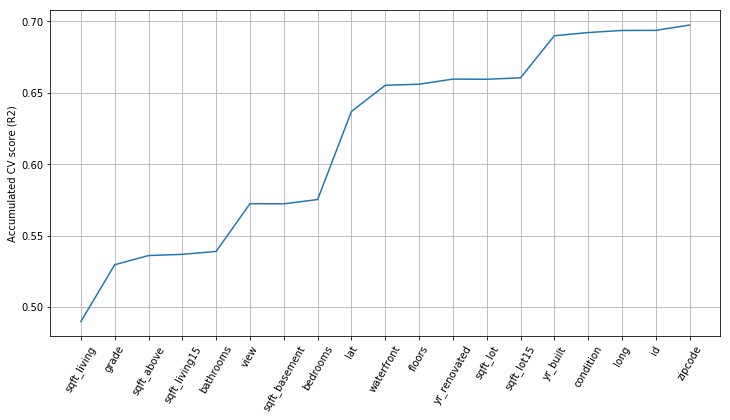

In [149]:
plt.figure(figsize=(12,6))
plt.plot(score_list)
plt.xticks(list(range(len(feat_list))), feat_list, rotation=60)
plt.ylabel('Accumulated CV score (R2)')
plt.grid()
plt.show()

## Recursive feature elimination

In [190]:
lr_normed = LinearRegression(normalize=True)

selector = RFE(lr_normed, 1, step=1)
selector.fit(X_trval.drop('date', axis=1), y_trval)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True),
  n_features_to_select=1, step=1, verbose=0)

In [191]:
selector.ranking_

array([19, 10, 11,  1, 18, 13,  4,  8,  9,  7,  2,  3, 12, 16, 14,  5,  6,
       15, 17])

In [200]:
X_trval.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [203]:
pd.Series(list(X_trval.drop('date', axis=1).columns), index=selector.ranking_).sort_index()

1       sqft_living
2        sqft_above
3     sqft_basement
4        waterfront
5               lat
6              long
7             grade
8              view
9         condition
10         bedrooms
11        bathrooms
12         yr_built
13           floors
14          zipcode
15    sqft_living15
16     yr_renovated
17       sqft_lot15
18         sqft_lot
19               id
dtype: object

In [208]:
feat_list = []
score_list = []
rfe_ranking = pd.Series(list(X_trval.drop('date', axis=1).columns), index=selector.ranking_).sort_index()
for feat in rfe_ranking:
    feat_list.append(feat)
    
    cvs = cross_val_score(estimator=lr, X=X_trval[feat_list], 
                                        y=y_trval, 
                                        cv=10, scoring='r2')
    print('Adding %-20s %.3f pm %.3f' % (feat, cvs.mean(), cvs.std()))
    score_list.append(cvs.mean())

Adding sqft_living          0.490 pm 0.025
Adding sqft_above           0.490 pm 0.025
Adding sqft_basement        0.490 pm 0.025
Adding waterfront           0.531 pm 0.031
Adding lat                  0.607 pm 0.026
Adding long                 0.618 pm 0.024
Adding grade                0.647 pm 0.020
Adding view                 0.660 pm 0.021
Adding condition            0.669 pm 0.020
Adding bedrooms             0.672 pm 0.020
Adding bathrooms            0.672 pm 0.020
Adding yr_built             0.692 pm 0.019
Adding floors               0.692 pm 0.019
Adding zipcode              0.696 pm 0.018
Adding sqft_living15        0.697 pm 0.018
Adding yr_renovated         0.697 pm 0.018
Adding sqft_lot15           0.697 pm 0.018
Adding sqft_lot             0.697 pm 0.018
Adding id                   0.697 pm 0.018


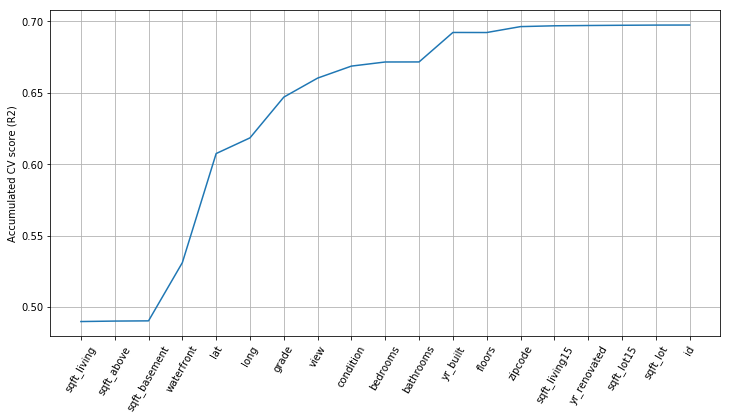

In [209]:
plt.figure(figsize=(12,6))
plt.plot(score_list)
plt.xticks(list(range(len(feat_list))), feat_list, rotation=60)
plt.ylabel('Accumulated CV score (R2)')
plt.grid()
plt.show()

# Create more features

## Add polynomial features

In [499]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_trval.drop('date', axis=1))

In [504]:
cvs = cross_val_score(estimator=lr, X=X_poly, 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.740 pm 0.035


In [343]:
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(X_trval.drop('date', axis=1))

In [344]:
cvs = cross_val_score(estimator=lr, X=X_poly, 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.632 pm 0.045


## PCA

In [286]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X_trval.drop('date', axis=1))

In [300]:
X_std.shape

(17290, 19)

In [305]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [306]:
pca.explained_variance_ratio_ .sum()

0.8552849821754757

In [307]:
X_pca = pca.transform(X_std)

In [308]:
X_pca.shape

(17290, 10)

In [309]:
cvs = cross_val_score(estimator=lr, X=X_pca, 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.665 pm 0.022


Polymerize

In [313]:
poly = PolynomialFeatures(3)
X_pca_poly = poly.fit_transform(X_pca)

In [314]:
X_pca_poly.shape

(17290, 286)

In [315]:
cvs = cross_val_score(estimator=lr, X=X_pca_poly, 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.784 pm 0.064


Second PCA attempt

In [379]:
pca = PCA(n_components=20)
X_std2 = StandardScaler().fit_transform(X_pca_poly)
X_pca2 = pca.fit_transform(X_std2)

pca.explained_variance_ratio_ .sum()

0.8464872679480107

In [380]:
poly = PolynomialFeatures(3)
X_pca2_poly = poly.fit_transform(X_pca2)

Pipeline

In [365]:
selector = RFE(lr_normed, 20, step=1)

#X_rfe = selector.fit_transform(X_poly, y_trval)

In [388]:

pipe = Pipeline([('std1', StandardScaler()),
                 ('pca1', PCA(n_components=11)),
                 ('poly1', PolynomialFeatures(3)),
                 #('std2', StandardScaler()),
                 #('rfe1', RFE(lr_normed, 5, step=1)),
                 #('pca2', PCA(n_components=20)),
                 ('lr', lr)])

cvs = cross_val_score(estimator=pipe, X=X_std, 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.804 pm 0.027


In [386]:
list(range(2,15))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [387]:
for n_components in range(2,15):
    pipe = Pipeline([('std1', StandardScaler()),
                 ('pca1', PCA(n_components=n_components)),
                 ('poly1', PolynomialFeatures(3)),
                 #('std2', StandardScaler()),
                 #('rfe1', RFE(lr_normed, 5, step=1)),
                 #('pca2', PCA(n_components=20)),
                 ('lr', lr)])
    cvs = cross_val_score(estimator=pipe, X=X_std, 
                                    y=y_trval, 
                                        cv=5, scoring='r2')
    print('n_components= %d :  %.3f pm %.3f' % (n_components, cvs.mean(), cvs.std()))

n_components= 2 :  0.645 pm 0.026
n_components= 3 :  0.656 pm 0.032
n_components= 4 :  0.673 pm 0.035
n_components= 5 :  0.683 pm 0.033
n_components= 6 :  0.685 pm 0.036
n_components= 7 :  0.672 pm 0.032
n_components= 8 :  0.766 pm 0.027
n_components= 9 :  0.756 pm 0.045
n_components= 10 :  0.787 pm 0.034
n_components= 11 :  0.795 pm 0.013
n_components= 12 :  0.758 pm 0.009
n_components= 13 :  0.723 pm 0.038
n_components= 14 :  0.209 pm 0.775


### Using a smaller dataset X_sm

In [266]:
X_sm, _, y_sm, _ = \
        train_test_split(X_trval, y_trval, test_size=0.8, random_state=7)
X_sm = X_sm.drop('date', axis=1)

In [267]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_sm)

In [268]:
cvs = cross_val_score(estimator=lr, X=X_poly, 
                                    y=y_sm, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.742 pm 0.040


In [269]:
poly = PolynomialFeatures(3)
X_poly3 = poly.fit_transform(X_sm)

In [271]:
cvs = cross_val_score(estimator=lr, X=X_poly3, 
                                    y=y_sm, 
                                    cv=2, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.512 pm 0.020


## Combine polynomials and RFE

Idea is to first add polynomials of degree 2, then cut features to 50, then add degree 3, etc.

In [226]:
#X_trval.drop('date', axis=1) # Original features

In [318]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_trval.drop('date', axis=1))

In [319]:
lr_normed = LinearRegression(normalize=True)
selector = RFE(lr_normed, 20, step=1)

X_rfe = selector.fit_transform(X_poly, y_trval)

In [320]:
cvs = cross_val_score(estimator=lr, X=X_rfe, 
                                    y=y_trval, 
                                    cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.590 pm 0.040


In [321]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_rfe)

In [322]:
X_rfe = selector.fit_transform(X_poly, y_trval)

In [323]:
cvs = cross_val_score(estimator=lr, X=X_rfe, 
                                    y=y_trval, 
                                    cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.549 pm 0.035


# Different Regression Algorithms

## By themselves

In [393]:
# Linear Regression
cvs = cross_val_score(estimator=lr, X=X_trval.drop('date', axis=1), 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.697 pm 0.018


In [415]:
# Ridge
from sklearn import linear_model
ridge = linear_model.Ridge(alpha=0.00000001)
cvs = cross_val_score(estimator=ridge, X=X_std, 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.697 pm 0.018


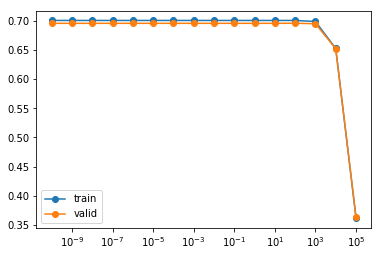

In [461]:
# Trying different alpha parameters for Ridge regression
from sklearn.model_selection import validation_curve
#test_int = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
test_int = np.logspace(-10, 5, 16)

ridge = linear_model.Ridge()
train_scores, valid_scores = validation_curve(ridge, X_std, y_trval, "alpha",
                                              test_int,
                                               cv=5)

plt.semilogx(test_int, np.mean(train_scores, axis=1), marker='o', label='train')
plt.semilogx(test_int, np.mean(valid_scores, axis=1), marker='o', label='valid')
plt.legend()
plt.show()

In [469]:
# Lasso
lasso = linear_model.Lasso(alpha=1)
cvs = cross_val_score(estimator=lasso, X=X_std, 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

0.697 pm 0.018


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [485]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(kernel='linear', C=1)
cvs = cross_val_score(estimator=svr, X=X_std, 
                                    y=y_trval, 
                                        cv=5, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.074 pm 0.010


In [489]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=0,
                              n_estimators=200)
cvs = cross_val_score(estimator=regr, X=X_std, 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.721 pm 0.020


## With PCA / Poly

In [507]:
pipe = Pipeline([('std1', StandardScaler()),
                 ('pca1', PCA(n_components=11)),
                 ('poly1', PolynomialFeatures(3)),
                 ('lr', lr)])

cvs = cross_val_score(estimator=pipe, X=X_trval.drop('date', axis=1), 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.804 pm 0.027


In [473]:
rigde = linear_model.Ridge(alpha=0.1, max_iter=3000)
pipe = Pipeline([('std1', StandardScaler()),
                 ('pca1', PCA(n_components=11)),
                 ('poly1', PolynomialFeatures(3)),
                 ('lr', ridge)])

cvs = cross_val_score(estimator=pipe, X=X_trval.drop('date', axis=1), 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

0.788 pm 0.036


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [474]:
lasso = linear_model.Lasso(alpha=0.1, max_iter=3000)
pipe = Pipeline([('std1', StandardScaler()),
                 ('pca1', PCA(n_components=11)),
                 ('poly1', PolynomialFeatures(3)),
                 ('lr', ridge)])

cvs = cross_val_score(estimator=pipe, X=X_trval.drop('date', axis=1), 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

0.788 pm 0.036


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [490]:
pipe = Pipeline([('std1', StandardScaler()),
                 ('pca1', PCA(n_components=11)),
                 ('poly1', PolynomialFeatures(3)),
                 ('lr', regr)])

cvs = cross_val_score(estimator=pipe, X=X_trval.drop('date', axis=1), 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

KeyboardInterrupt: 

## Random Forest with poly

In [493]:
pipe = Pipeline([('std1', StandardScaler()),
                 #('pca1', PCA(n_components=11)),
                 ('poly1', PolynomialFeatures(2)),
                 ('lr', lr)])

cvs = cross_val_score(estimator=pipe, X=X_trval.drop('date', axis=1), 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.812 pm 0.026


In [495]:
regr = RandomForestRegressor(max_depth=2, random_state=0,
                              n_estimators=100)

pipe = Pipeline([('std1', StandardScaler()),
                 #('pca1', PCA(n_components=11)),
                 ('poly1', PolynomialFeatures(2)),
                 ('lr', regr)])

cvs = cross_val_score(estimator=pipe, X=X_trval.drop('date', axis=1), 
                                    y=y_trval, 
                                        cv=10, scoring='r2')
print('%.3f pm %.3f' % (cvs.mean(), cvs.std()))

0.567 pm 0.026
